In [ ]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Processing 
import os
import os.path
import random
import PIL
import glob
from PIL import Image # to read images
#
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Use Keras Model Architecture 

In [ ]:
#For Keras model
import keras
from keras.models import Sequential,Model
from keras.applications import ResNet50
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing import image
from keras import backend as k
import tensorflow as tf
from tensorflow.python.keras.optimizers import TFOptimizer

In [ ]:
config = tf.compat.v1.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True
%load_ext autoreload
%autoreload 2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Dataset Preparation 

In [ ]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [ ]:
path = "/content/drive/My Drive/"
annot = "/content/drive/My Drive/annotations.json"

In [ ]:
anns_file_path

'./data/annotations.json'

In [ ]:
# Read Annotations
with open(annot , 'r') as f:
    dataset = json.loads(f.read())

In [ ]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [ ]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [ ]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [ ]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000006.jpg,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",403954.0,"[517.0, 127.0, 447.0, 1322.0]",0,Glass bottle
1,batch_1/000012.jpg,"[[481.0, 1148.0, 505.0, 1163.0, 519.0, 1172.0,...",43489.0,"[379.0, 1127.0, 425.0, 318.0]",0,Glass bottle
2,batch_1/000048.jpg,"[[586.0, 820.0, 581.0, 851.0, 579.0, 889.0, 58...",324005.0,"[211.0, 1.0, 417.0, 1417.0]",0,Glass bottle
3,batch_1/000021.jpg,"[[1001.0, 867.0, 1163.0, 905.0, 1199.0, 913.0,...",95494.5,"[852.0, 638.0, 687.0, 291.0]",0,Glass bottle
4,batch_1/000022.jpg,"[[919.0, 1125.0, 968.0, 1111.0, 1000.0, 1100.0...",142823.0,"[647.0, 1033.0, 820.0, 376.0]",0,Glass bottle


In [ ]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [ ]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [ ]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000006.jpg,Glass bottle,517.0,127.0,447.0,1322.0
1,batch_1/000012.jpg,Glass bottle,379.0,1127.0,425.0,318.0
2,batch_1/000048.jpg,Glass bottle,211.0,1.0,417.0,1417.0
3,batch_1/000021.jpg,Glass bottle,852.0,638.0,687.0,291.0
4,batch_1/000022.jpg,Glass bottle,647.0,1033.0,820.0,376.0


In [ ]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

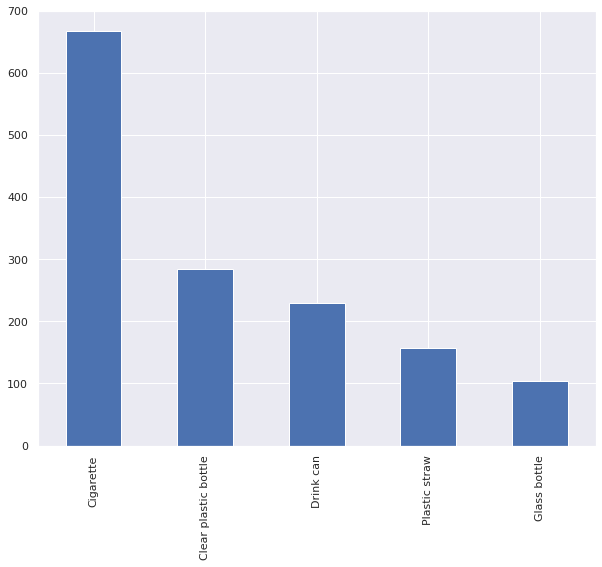

In [ ]:
df['category'].value_counts().plot.bar()

Data splitting into train and test data and keep this test data aside for model prediction
train_df, test_df = train_test_split(df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Fetch, crop and store image data

In [ ]:
# path of the folder containing the original images 
inPath = path+'data' 
# path of the folder that will contain the cropped image 
outPath = path+'trainDataTACO' 
train_data = []  
for ind in df.index:
  bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
  imagePath = os.path.join(inPath+'/'+df['filename'][ind])
  img = Image.open(imagePath)
  img = img.crop(bbox)
  fullOutPath = os.path.join(outPath +'/'+df['filename'][ind]) 
  img.save(fullOutPath)

In [ ]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)
df.head()

,filename,category
0,batch_1/000006.jpg,Glass bottle
1,batch_1/000012.jpg,Glass bottle
2,batch_1/000048.jpg,Glass bottle
3,batch_1/000021.jpg,Glass bottle
4,batch_1/000022.jpg,Glass bottle


In [ ]:
df = df.astype({"category":'category'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442 entries, 0 to 1441
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   filename  1442 non-null   object  
 1   category  1442 non-null   category
dtypes: category(1), object(1)
memory usage: 24.1+ KB


### Data Split 

In [ ]:
# Data split Randomly
trainData_df, testData_df = train_test_split(df, test_size=0.20, random_state=42,stratify = df['category'] )


In [ ]:
print(trainData_df.shape)
print(testData_df.shape)

(1153, 2)
(289, 2)


#### Global Constants 

In [70]:
# Fixed for our 'Cigarette','Clear plastic bottle','Drink can','Plastic straw','Glass bottle' classes
NUM_CLASSES = 5
CHANNELS = 3

#
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
input_shape = (IMAGE_RESIZE,IMAGE_RESIZE,CHANNELS)
# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 200
EARLY_STOP_PATIENCE = 3
FAST_RUN = False

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 50
BATCH_SIZE_VALIDATION = 10

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [ ]:
resnet_weights_path = path + 'resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
#Still not talking about our train/test data or any pre-processing.

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

94658560/94653016 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
from tensorflow.python.keras import optimizers

In [ ]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = 'adam', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.10)

In [ ]:
# Train image data generator
# Create new train folder directory which should have images
newPath = path +'trainDataTACO'
train_generator=data_generator.flow_from_dataframe(
    dataframe=trainData_df,
    directory=newPath,
    x_col="filename",
    y_col="category",
    subset="training",
    batch_size=BATCH_SIZE_TRAINING,
    seed=21,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 1038 validated image filenames belonging to 5 classes.


In [ ]:
# Validation image data generator
validation_generator=data_generator.flow_from_dataframe(
    dataframe=trainData_df,
    directory=newPath,
    x_col="filename",
    y_col="category",
    subset="validation",
    batch_size=BATCH_SIZE_TRAINING,
    seed=21,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 115 validated image filenames belonging to 5 classes.


In [ ]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(50, 21, 10, 3)

In [68]:
filepath_model = path + '/resnet50/working/best.hdf5'
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = filepath_model, monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [71]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights(filepath_model)

Epoch 1/200
10/10 [==============================] - 6s 647ms/step - loss: 0.5683 - accuracy: 0.8156 - val_loss: 1.1783 - val_accuracy: 0.6810
Epoch 2/200
10/10 [==============================] - 5s 522ms/step - loss: 0.6118 - accuracy: 0.7860 - val_loss: 0.9915 - val_accuracy: 0.6810
Epoch 3/200
10/10 [==============================] - 6s 592ms/step - loss: 0.5653 - accuracy: 0.7910 - val_loss: 0.9254 - val_accuracy: 0.6972
Epoch 4/200
10/10 [==============================] - 5s 522ms/step - loss: 0.5259 - accuracy: 0.8140 - val_loss: 1.1670 - val_accuracy: 0.6709
Epoch 5/200
10/10 [==============================] - 6s 624ms/step - loss: 0.5059 - accuracy: 0.8340 - val_loss: 1.3782 - val_accuracy: 0.6759
Epoch 6/200
10/10 [==============================] - 5s 504ms/step - loss: 0.4609 - accuracy: 0.8463 - val_loss: 1.0075 - val_accuracy: 0.6583


In [72]:
print(fit_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


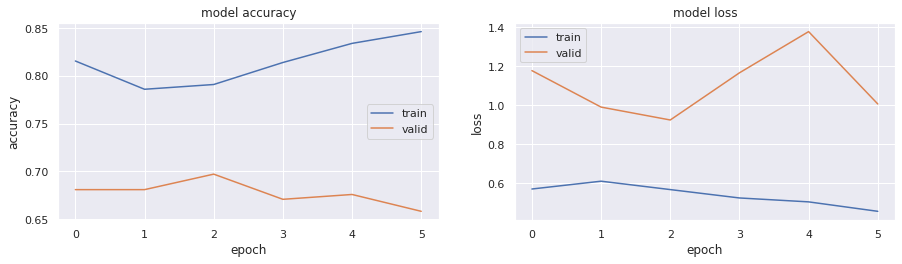

In [75]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [76]:
# test image data generator
test_generator=data_generator.flow_from_dataframe(
    dataframe=testData_df,
    directory=newPath,
    x_col="filename",
    y_col="category",
    batch_size=BATCH_SIZE_TESTING,
    seed=21,
    shuffle=False,
    class_mode=None,
    target_size=(IMAGE_RESIZE,IMAGE_RESIZE)
)

Found 289 validated image filenames.


In [77]:
# Reset before each call to predict
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

289/289 [==============================] - 6s 21ms/step


In [78]:
predicted_class_indices

array([0, 0, 4, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       4, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 4, 0, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 3, 3, 1, 1, 4, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 1, 0, 4, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 3, 0, 0, 1, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 4, 0, 0, 0, 0, 1, 0, 4,
       1, 0, 0])

In [80]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(testData_df['filename']), 
        'label': pd.Series(predicted_class_indices)
    })

In [81]:
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

results_df.to_csv('submission.csv', index=False)
results_df.head()

,id,label
0,1.0,0.0
391,1.0,NaN
104,1.0,1.0
106,1.0,0.0
108,1.0,0.0
